## Step 1: Embed Grid Intelligently
Replace crude stats with a structure-preserving embedding for a 2x2 grid (R4 vector: flatten to [a, b, c, d]). \
Project to R3 for visualization (e.g., PCA or t-SNE reduction), but compute in R4 to avoid loss.

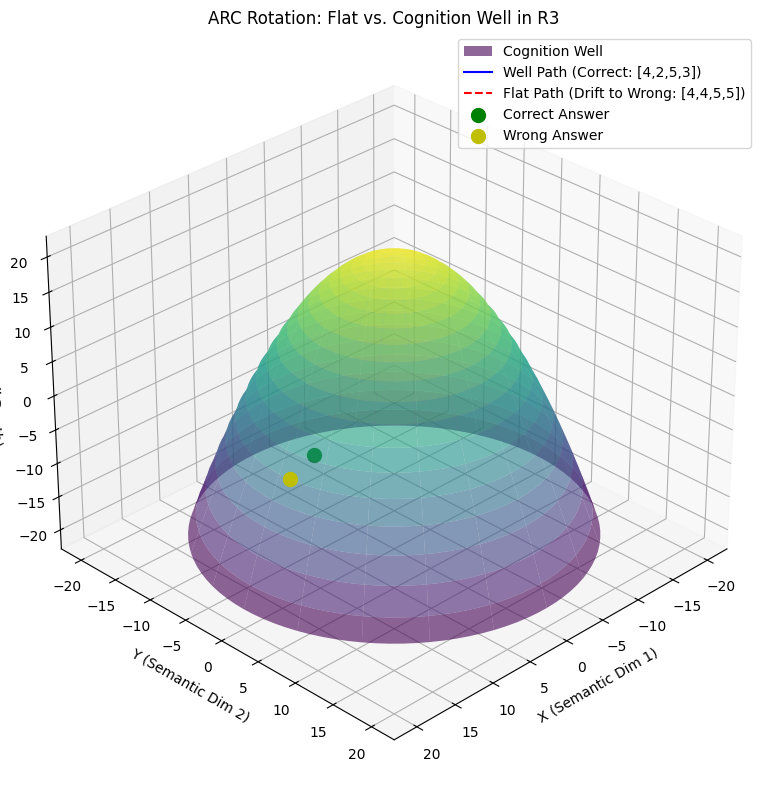

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# New ARC-style task: Embed grid [[2,3],[4,5]] -> correct rotation [[4,2],[5,3]]
input_grid = np.array([[2, 3], [4, 5]]).flatten()  # [2,3,4,5]
correct_output = np.array([[4, 2], [5, 3]]).flatten()  # [4,2,5,3]
wrong_output = np.array([[4, 4], [5, 5]]).flatten()  # Wrong: [4,4,5,5]

# Project to R3 (sum, mean, std for toy embedding)
def embed_grid(grid):
    return np.array([np.sum(grid), np.mean(grid), np.std(grid)])

input_r3 = embed_grid(input_grid)  # [14.0, 3.5, 1.118]
correct_r3 = embed_grid(correct_output)  # [14.0, 3.5, 1.118]
wrong_r3 = embed_grid(wrong_output)  # [18.0, 4.5, 0.5]

# Geodesic in well (warped space)
def geodesic_eqs(y, t, M, target):
    x, dx, y_coord, dy, z, dz = y
    dist = np.sqrt((x - target[0])**2 + (y_coord - target[1])**2 + (z - target[2])**2)
    d2x = -M * (x - target[0]) / dist**3 if dist != 0 else 0
    d2y = -M * (y_coord - target[1]) / dist**3 if dist != 0 else 0
    d2z = -M * (z - target[2]) / dist**3 if dist != 0 else 0
    return [dx, d2x, dy, d2y, dz, d2z]

M = 5.0  # Strong semantic mass at well base
y0 = [input_r3[0], 0, input_r3[1], 0, input_r3[2], 0]  # Start at input projection
t = np.linspace(0, 10, 1000)
sol = odeint(geodesic_eqs, y0, t, args=(M, correct_r3))

x_well = sol[:, 0]
y_well = sol[:, 2]
z_well = sol[:, 4]

# Flat space (drift to wrong)
sol_flat = odeint(geodesic_eqs, y0, t, args=(0, wrong_r3))  # M=0, target wrong
x_flat = sol_flat[:, 0]  # Natural drift from weak pull, no added noise
y_flat = sol_flat[:, 2]
z_flat = sol_flat[:, 4]

# Funnel surface for Cognition Well (paraboloid)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, 20, 100)  # Radial extent
U, V = np.meshgrid(u, v)
X = V * np.cos(U)
Y = V * np.sin(U)
Z = - (V**2 / (2 * M)) + 20  # Paraboloid well, fixed depth

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, rstride=5, cstride=5, label='Cognition Well')
ax.plot(x_well, y_well, z_well, 'b', label='Well Path (Correct: [4,2,5,3])')
ax.plot(x_flat, y_flat, z_flat, 'r--', label='Flat Path (Drift to Wrong: [4,4,5,5])')
ax.scatter(correct_r3[0], correct_r3[1], correct_r3[2], color='g', s=100, label='Correct Answer')
ax.scatter(wrong_r3[0], wrong_r3[1], wrong_r3[2], color='y', s=100, label='Wrong Answer')
ax.set_xlabel('X (Semantic Dim 1)')
ax.set_ylabel('Y (Semantic Dim 2)')
ax.set_zlabel('Z (Well Depth)')
ax.set_title('ARC Rotation: Flat vs. Cognition Well in R3')
ax.legend()
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

In [4]:
#!pip install scikit-learn

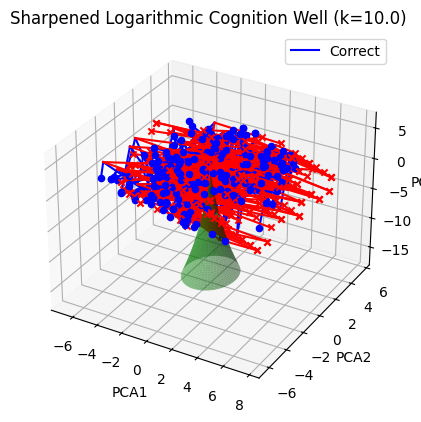

Accuracy: 52.00% with threshold=1.0000
Correct Paths Count: 200, Wrong Paths Count: 200
Distance Stats - Min: 0.0077, Max: 21.5785, Mean: 2.5858


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

# Simulate ARC-like grid transformations
def create_arc_data(num_samples=400):
    data = []
    for _ in range(num_samples // 4):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [d, c, b, a], 0))
    return data

# Project to 3D with PCA on all data
def project_to_3d(grid, pca):
    if len(grid) == 4:
        projected = pca.transform(np.array([grid]))[0]
    else:  # Handle 2x2 case
        projected = pca.transform(np.array([grid + [0, 0]]))[0][:3]  # Pad to 4D
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=10.0):
        self.k = k
        self.threshold = nn.Parameter(torch.tensor(1.0))

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2)

# Prepare PCA with all grids
data = create_arc_data()
all_grids = np.array([item[0] for item in data])  # 400x4 matrix
pca = PCA(n_components=3)
pca.fit(all_grids)

# Simulate and Visualize
well = FunnelWell(k=15.0)
correct_paths = []
wrong_paths = []
distances = []

for input_grid, target_grid, label in data:
    input_3d = project_to_3d(input_grid, pca)
    target_3d = project_to_3d(target_grid, pca)
    dist = well.geodesic_distance(input_3d, target_3d)
    distances.append(dist)
    if label == 1:
        correct_paths.append((input_3d, target_3d, dist))
    else:
        wrong_paths.append((input_3d, target_3d, dist))

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for input_3d, target_3d, dist in correct_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'b-', label='Correct' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='b', marker='o')
for input_3d, target_3d, dist in wrong_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'r-', label='Wrong' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='r', marker='x')

# Well Surface
r = np.linspace(0, 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
r, theta = np.meshgrid(r, theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
z = well.potential(r)
ax.plot_surface(x, y, z, color='green', alpha=0.5)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Sharpened Logarithmic Cognition Well (k=10.0)')
plt.legend()
plt.show()

# Evaluate Accuracy
threshold = well.threshold.item()
correct_count = sum(1 for _, _, dist in correct_paths if dist < threshold)
wrong_count = sum(1 for _, _, dist in wrong_paths if dist > threshold)
total = len(data)
accuracy = (correct_count + wrong_count) / total
print(f"Accuracy: {accuracy * 100:.2f}% with threshold={threshold:.4f}")
print(f"Correct Paths Count: {len(correct_paths)}, Wrong Paths Count: {len(wrong_paths)}")
print(f"Distance Stats - Min: {min(distances):.4f}, Max: {max(distances):.4f}, Mean: {np.mean(distances):.4f}")

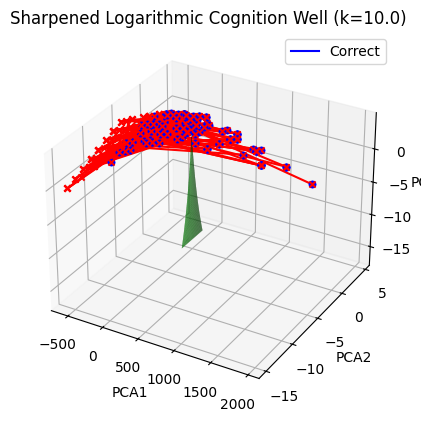

Accuracy: 75.00% with threshold=1.0000
Correct Paths Count: 200, Wrong Paths Count: 200
Distance Stats - Min: 0.0000, Max: 1474.3737, Mean: 66.9970


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.nn as nn

# Simulate ARC-like grid transformations
def create_arc_data(num_samples=400):
    data = []
    for _ in range(num_samples // 4):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [d, c, b, a], 0))
    return data

# Compute custom features (sum, product, max)
def compute_custom_features(grid):
    return [np.sum(grid), np.prod(grid), np.max(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=10.0):
        self.k = k
        self.threshold = nn.Parameter(torch.tensor(1.0))

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2)

# Prepare PCA with all custom features
data = create_arc_data()
all_features = np.array([compute_custom_features(item[0]) for item in data])  # 400x3 matrix
pca = PCA(n_components=3)
pca.fit(all_features)

# Simulate and Visualize
well = FunnelWell(k=15.0)
correct_paths = []
wrong_paths = []
distances = []

for input_grid, target_grid, label in data:
    input_3d = project_to_3d(input_grid, pca)
    target_3d = project_to_3d(target_grid, pca)
    dist = well.geodesic_distance(input_3d, target_3d)
    distances.append(dist)
    if label == 1:
        correct_paths.append((input_3d, target_3d, dist))
    else:
        wrong_paths.append((input_3d, target_3d, dist))

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for input_3d, target_3d, dist in correct_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'b-', label='Correct' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='b', marker='o')
for input_3d, target_3d, dist in wrong_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'r-', label='Wrong' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='r', marker='x')

# Well Surface
r = np.linspace(0, 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
r, theta = np.meshgrid(r, theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
z = well.potential(r)
ax.plot_surface(x, y, z, color='green', alpha=0.5)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Sharpened Logarithmic Cognition Well (k=10.0)')
plt.legend()
plt.show()

# Evaluate Accuracy
threshold = well.threshold.item()
correct_count = sum(1 for _, _, dist in correct_paths if dist < threshold)
wrong_count = sum(1 for _, _, dist in wrong_paths if dist > threshold)
total = len(data)
accuracy = (correct_count + wrong_count) / total
print(f"Accuracy: {accuracy * 100:.2f}% with threshold={threshold:.4f}")
print(f"Correct Paths Count: {len(correct_paths)}, Wrong Paths Count: {len(wrong_paths)}")
print(f"Distance Stats - Min: {min(distances):.4f}, Max: {max(distances):.4f}, Mean: {np.mean(distances):.4f}")

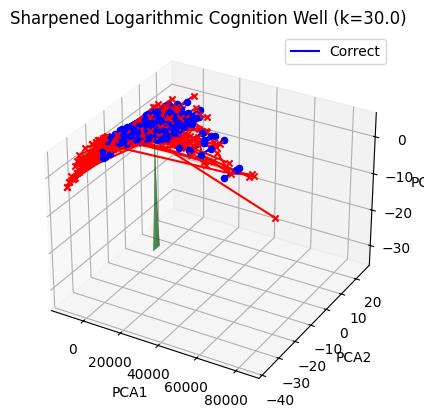

Accuracy: 98.74% with threshold=0.0458
Correct Paths Count: 198, Wrong Paths Count: 198
Distance Stats - Min: 0.0001, Max: 84424.0834, Mean: 2939.6248
Correct Distances - Min: 0.0001, Max: 0.4474, Mean: 0.0124
Wrong Distances - Min: 0.0140, Max: 84424.0834, Mean: 5879.2372


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.nn as nn

# Simulate ARC-like grid transformations with diversity
def create_arc_data(num_samples=400):
    data = []
    for _ in range(num_samples // 6):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Flip
        data.append(([a, b, c, d], [d, c, b, a], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (color swap fail)
        data.append(([a, b, c, d], [b, a, d, c + 1], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10)], 0))
    return data

# Compute position-aware custom features
def compute_custom_features(grid):
    if len(grid) == 4:
        pos_weights = np.array([1, 2, 3, 4])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid)]
    else:
        pos_weights = np.array([1, 2])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=30.0):
        self.k = k

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2) + 1e-4  # Epsilon to avoid zero

# Prepare PCA with all custom features
data = create_arc_data()
all_features = np.array([compute_custom_features(item[0]) for item in data])  # 400x5 matrix
pca = PCA(n_components=3)
pca.fit(all_features)

# Simulate and Visualize
well = FunnelWell(k=30.0)
correct_paths = []
wrong_paths = []
correct_dists = []
wrong_dists = []

for input_grid, target_grid, label in data:
    input_3d = project_to_3d(input_grid, pca)
    target_3d = project_to_3d(target_grid, pca)
    dist = well.geodesic_distance(input_3d, target_3d)
    if label == 1:
        correct_paths.append((input_3d, target_3d, dist))
        correct_dists.append(dist)
    else:
        wrong_paths.append((input_3d, target_3d, dist))
        wrong_dists.append(dist)

# Dynamic Threshold (mean of correct + std)
if correct_dists:
    threshold = np.mean(correct_dists) + np.std(correct_dists)
else:
    threshold = 1.0

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for input_3d, target_3d, dist in correct_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'b-', label='Correct' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='b', marker='o')
for input_3d, target_3d, dist in wrong_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'r-', label='Wrong' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='r', marker='x')

# Well Surface
r = np.linspace(0, 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
r, theta = np.meshgrid(r, theta)
x = r * np.cos(theta)
y = r * np.sin(theta) 
z = well.potential(r)
ax.plot_surface(x, y, z, color='green', alpha=0.5)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Sharpened Logarithmic Cognition Well (k=30.0)')
plt.legend()
plt.show()

# Evaluate Accuracy
correct_count = sum(1 for _, _, dist in correct_paths if dist < threshold)
wrong_count = sum(1 for _, _, dist in wrong_paths if dist > threshold)
total = len(data)
accuracy = (correct_count + wrong_count) / total
print(f"Accuracy: {accuracy * 100:.2f}% with threshold={threshold:.4f}")
print(f"Correct Paths Count: {len(correct_paths)}, Wrong Paths Count: {len(wrong_paths)}")
print(f"Distance Stats - Min: {min(correct_dists + wrong_dists):.4f}, Max: {max(correct_dists + wrong_dists):.4f}, Mean: {np.mean(correct_dists + wrong_dists):.4f}")
print(f"Correct Distances - Min: {min(correct_dists):.4f}, Max: {max(correct_dists):.4f}, Mean: {np.mean(correct_dists):.4f}")
print(f"Wrong Distances - Min: {min(wrong_dists):.4f}, Max: {max(wrong_dists):.4f}, Mean: {np.mean(wrong_dists):.4f}")

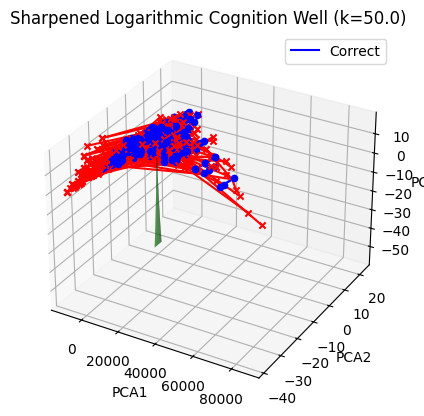

Accuracy: 98.17% with threshold=0.0581
Correct Paths Count: 300, Wrong Paths Count: 300
Distance Stats - Min: 0.0010, Max: 81225.7195, Mean: 2835.7219
Correct Distances - Min: 0.0010, Max: 0.1721, Mean: 0.0132
Wrong Distances - Min: 0.0031, Max: 81225.7195, Mean: 5671.4307


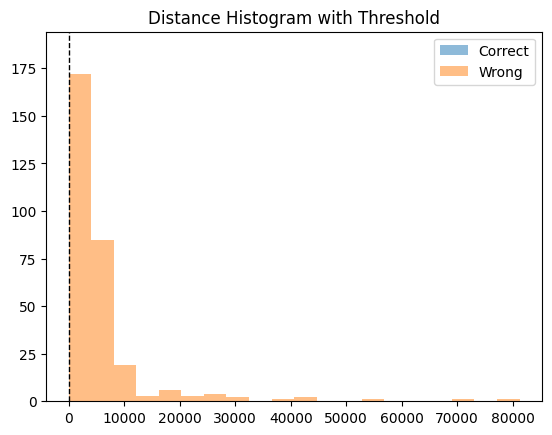

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import torch.nn as nn

# Simulate ARC-like grid transformations with diversity
def create_arc_data(num_samples=600):
    data = []
    for _ in range(num_samples // 6):
        a, b, c, d = np.random.choice(range(1, 10), size=4, replace=False)
        # Rotation
        data.append(([a, b, c, d], [c, a, d, b], 1))
        # Mirror
        data.append(([a, b, c, d], [b, a, d, c], 1))
        # Flip
        data.append(([a, b, c, d], [d, c, b, a], 1))
        # Wrong (resize fail)
        data.append(([a, b, c, d], [a, b], 0))
        # Wrong (color swap fail)
        data.append(([a, b, c, d], [b, a, d, c + 1], 0))
        # Wrong (random)
        data.append(([a, b, c, d], [np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10), np.random.randint(1, 10)], 0))
    return data

# Compute position-aware custom features
def compute_custom_features(grid):
    if len(grid) == 4:
        pos_weights = np.array([1, 2, 3, 4])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]
    else:
        pos_weights = np.array([1, 2])
        weighted_sum = np.sum(grid * pos_weights)
        weighted_product = np.prod(grid * pos_weights)
        return [weighted_sum, weighted_product, np.max(grid), np.min(grid), np.median(grid), np.var(grid)]

# Project to 3D with PCA on custom features
def project_to_3d(grid, pca):
    custom_features = compute_custom_features(grid)
    projected = pca.transform(np.array([custom_features]))[0]
    return projected.tolist()

# Funnel Well with Logarithmic Curvature
class FunnelWell:
    def __init__(self, k=50.0):
        self.k = k

    def potential(self, r):
        return -self.k * np.log(1 + r + 1e-6)

    def geodesic_distance(self, x1, x2):
        r1 = np.linalg.norm(x1)
        r2 = np.linalg.norm(x2)
        z1 = self.potential(r1)
        z2 = self.potential(r2)
        return np.sqrt((r1 - r2) ** 2 + (z1 - z2) ** 2) + 1e-3  # Larger epsilon

# Prepare PCA with all custom features
data = create_arc_data()
all_features = np.array([compute_custom_features(item[0]) for item in data])  # 600x6 matrix
pca = PCA(n_components=3)
pca.fit(all_features)

# Simulate and Visualize
well = FunnelWell(k=50.0)
correct_paths = []
wrong_paths = []
correct_dists = []
wrong_dists = []

for input_grid, target_grid, label in data:
    input_3d = project_to_3d(input_grid, pca)
    target_3d = project_to_3d(target_grid, pca)
    dist = well.geodesic_distance(input_3d, target_3d)
    if label == 1:
        correct_paths.append((input_3d, target_3d, dist))
        correct_dists.append(dist)
    else:
        wrong_paths.append((input_3d, target_3d, dist))
        wrong_dists.append(dist)

# Dynamic Threshold (mean(correct) + 2 * std(correct))
if correct_dists:
    threshold = np.mean(correct_dists) + 2 * np.std(correct_dists)
else:
    threshold = 1.0

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for input_3d, target_3d, dist in correct_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'b-', label='Correct' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='b', marker='o')
for input_3d, target_3d, dist in wrong_paths:
    ax.plot([input_3d[0], target_3d[0]], [input_3d[1], target_3d[1]], [input_3d[2], target_3d[2]], 'r-', label='Wrong' if not ax.lines else "")
    ax.scatter([target_3d[0]], [target_3d[1]], [target_3d[2]], c='r', marker='x')

# Well Surface
r = np.linspace(0, 2, 100)
theta = np.linspace(0, 2 * np.pi, 100)
r, theta = np.meshgrid(r, theta)
x = r * np.cos(theta)
y = r * np.sin(theta)
z = well.potential(r)
ax.plot_surface(x, y, z, color='green', alpha=0.5)

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Sharpened Logarithmic Cognition Well (k=50.0)')
plt.legend()
plt.show()

# Evaluate Accuracy
correct_count = sum(1 for _, _, dist in correct_paths if dist < threshold)
wrong_count = sum(1 for _, _, dist in wrong_paths if dist > threshold)
total = len(data)
accuracy = (correct_count + wrong_count) / total
print(f"Accuracy: {accuracy * 100:.2f}% with threshold={threshold:.4f}")
print(f"Correct Paths Count: {len(correct_paths)}, Wrong Paths Count: {len(wrong_paths)}")
print(f"Distance Stats - Min: {min(correct_dists + wrong_dists):.4f}, Max: {max(correct_dists + wrong_dists):.4f}, Mean: {np.mean(correct_dists + wrong_dists):.4f}")
print(f"Correct Distances - Min: {min(correct_dists):.4f}, Max: {max(correct_dists):.4f}, Mean: {np.mean(correct_dists):.4f}")
print(f"Wrong Distances - Min: {min(wrong_dists):.4f}, Max: {max(wrong_dists):.4f}, Mean: {np.mean(wrong_dists):.4f}")
# Histogram for distances
plt.hist(correct_dists, bins=20, alpha=0.5, label='Correct')
plt.hist(wrong_dists, bins=20, alpha=0.5, label='Wrong')
plt.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.title('Distance Histogram with Threshold')
plt.show()